# Lab 1 Bode Plot
---

Generate a bode magnitude and phase plot for the wave data collected.

Counts/rev = 3704.4

new counts/rev = 3600

Platen gear teeth = 60

Spur gear teeth = 10

Motor internal gear reduction = 50:1

Motor encoder = 12:1

Total gear reduction = $ \frac{60}{10}*\frac{50}{1}*\frac{12}{1}=3600:1 $ NOT 3704.4!!! >:(


---

In [47]:
import pandas as pd
import matplotlib as plt
import numpy as np

In [48]:
# Import data from csv file, create headers for each column based on the LabView VI.
df = pd.read_csv('test2_fixed.csv', index_col=False, skiprows=26, delimiter='\t',
                names=['time_s', 'cmd_sig', 'ang_deg', 'vel_deg_s', 'amp', 'freq_hz',
                         'sin0_or_sqr1'])
df.head()

,time_s,cmd_sig,ang_deg,vel_deg_s,amp,freq_hz,sin0_or_sqr1
0,0.013267,1.403746,0.000362,-0.034331,350.0,0.05,0.0
1,0.013767,1.458735,0.001747,-0.186879,350.0,0.05,0.0
2,0.014267,1.513712,0.004329,-0.522995,350.0,0.05,0.0
3,0.014767,1.568700,0.007877,-1.048937,350.0,0.05,0.0
4,0.015267,1.623689,0.012182,-1.727626,350.0,0.05,0.0


In [49]:
# Create new columns for 

df.insert(3, "ang_rad", df["ang_deg"].to_numpy()*np.pi/180, True)   # Rotation angle in Radians
df.insert(7, 'freq_rad', df['freq_hz'].to_numpy()*2*np.pi, True)    # Frequency in radians/sec for use in least squares fit
df.insert(5, 'vel_rad', np.deg2rad(df['vel_deg_s'].to_numpy()), True)   # Platen angular velocity in radians/sec
df.insert(2, 'cmd_volts', (df['cmd_sig'].to_numpy()*(1023+65)/1023)*9/1023)   # Calculate true command voltage by adding turn-on
                                                                    # command offset dividing by PWM resolution and
                                                                    # multiplying by DC power supply voltage (9V)
df.head()

,time_s,cmd_sig,cmd_volts,ang_deg,ang_rad,vel_deg_s,vel_rad,amp,freq_hz,freq_rad,sin0_or_sqr1
0,0.013267,1.403746,0.013134,0.000362,0.000006,-0.034331,-0.000599,350.0,0.05,0.314159,0.0
1,0.013767,1.458735,0.013649,0.001747,0.000030,-0.186879,-0.003262,350.0,0.05,0.314159,0.0
2,0.014267,1.513712,0.014163,0.004329,0.000076,-0.522995,-0.009128,350.0,0.05,0.314159,0.0
3,0.014767,1.568700,0.014678,0.007877,0.000137,-1.048937,-0.018307,350.0,0.05,0.314159,0.0
4,0.015267,1.623689,0.015192,0.012182,0.000213,-1.727626,-0.030153,350.0,0.05,0.314159,0.0


<Axes: xlabel='time_s'>

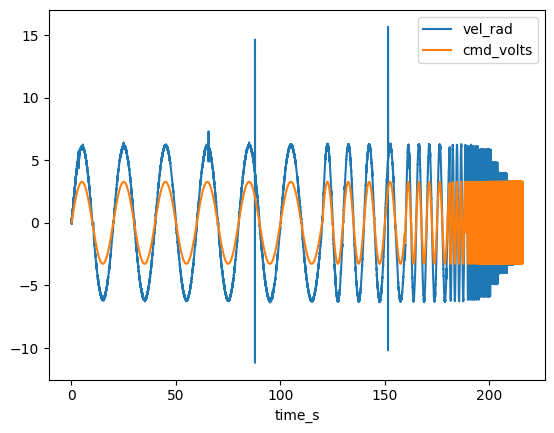

In [50]:
df.plot(x="time_s", y=[ "vel_rad", 'cmd_volts'])

In [51]:
frequencies = df['freq_hz'].unique().tolist()
print(frequencies)
frequency = frequencies[10]
frequency_rad = frequency*2*np.pi

[0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 7.5, 10.0, 15.0, 20.0]


<Axes: xlabel='time_s'>

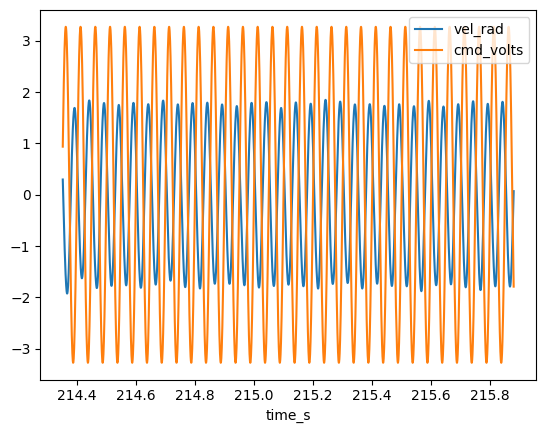

In [52]:
freq_data = df[df['freq_hz'] == frequency]
freq_data = freq_data.drop(freq_data.index[-150:0])
freq_data = freq_data.drop(freq_data.index[0:150])
freq_data.plot(x="time_s", y=["vel_rad", 'cmd_volts'])

<Axes: xlabel='time_s'>

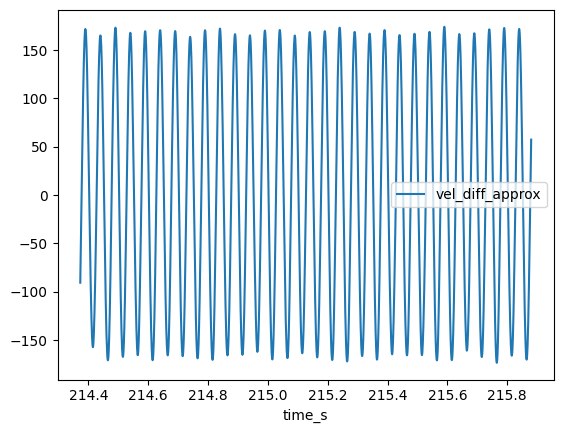

In [53]:
freq_data.insert(5, 'vel_diff_approx', freq_data['vel_rad'].diff(40)/freq_data['time_s'].diff(40), True)
freq_data.plot(x="time_s", y="vel_diff_approx")
#freq_data.at[10,'vel_diff_approx']

In [54]:
# Outlier Filtering for low frequencies
if frequency < 0.05:
    outliers = freq_data[abs(freq_data['vel_diff_approx']) > 40].index
    freq_data = freq_data.drop(outliers)
    freq_data.plot(x='time_s', y='vel_diff_approx')
    outliers


<Axes: xlabel='time_s'>

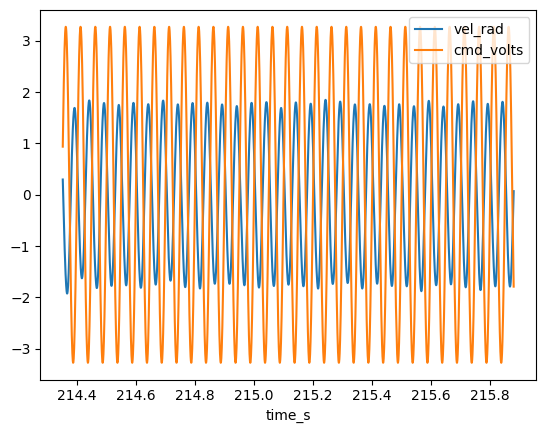

In [55]:
freq_data.plot(x="time_s", y=["vel_rad", 'cmd_volts'])

In [56]:
freq_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3051 entries, 428233 to 431283
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time_s           3051 non-null   float64
 1   cmd_sig          3051 non-null   float64
 2   cmd_volts        3051 non-null   float64
 3   ang_deg          3051 non-null   float64
 4   ang_rad          3051 non-null   float64
 5   vel_diff_approx  3011 non-null   float64
 6   vel_deg_s        3051 non-null   float64
 7   vel_rad          3051 non-null   float64
 8   amp              3051 non-null   float64
 9   freq_hz          3051 non-null   float64
 10  freq_rad         3051 non-null   float64
 11  sin0_or_sqr1     3051 non-null   float64
dtypes: float64(12)
memory usage: 309.9 KB


---

## Fit function to data using LLSQ

In [57]:
from scipy.optimize import leastsq

In [58]:
# Sine function least squares fit function using scipy.optimize.leastsq
# Inputs: time series, function frequency, initial guess for mean, phase, and amplitude, and the data series to fit to
# Outputs: list of sin function coefficients. [amplitude, phase, mean]
def sin_fit(time, freq, guess_mean, guess_phase, guess_amp, data):
    optimize_func = lambda x: x[0]*np.sin(freq*time+x[1]) + x[2] - data
    return leastsq(optimize_func, [guess_amp, guess_phase, guess_mean])[0]

[-1.76580868 -0.26020546  0.00231477]


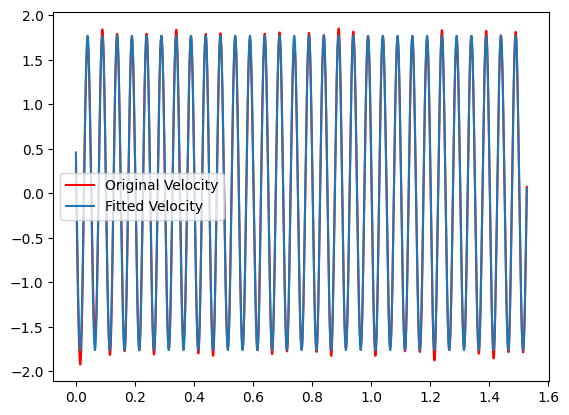

In [59]:
# Assign variables, for use in least squares fit function
time = freq_data['time_s'].to_numpy()-freq_data['time_s'].to_numpy()[0] # Time data normalized to start at 0 for accurate phase shift.
freq = frequency_rad    # Frequency in radians/sec
data = freq_data['vel_rad'].to_numpy()  # velocity data in radians/sec because the np.sin function takes radians
coef_vel_fit = sin_fit(time, freq, 0, 0, 1, data) # Generate sine function coefficients
vel_fit = coef_vel_fit[0]*np.sin(freq*time+coef_vel_fit[1])+coef_vel_fit[2] # Fitted function for velociy in radians/sec
print(coef_vel_fit)

# Plot fitted function and original amplitude data
plt.pyplot.plot(time, freq_data['vel_rad'], "r", time, vel_fit)
plt.pyplot.legend(['Original Velocity', 'Fitted Velocity'])

[ 3.27478247e+00  2.90423156e-01 -6.99152904e-05]


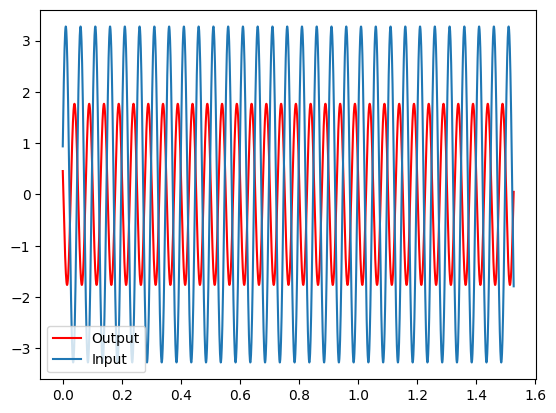

In [60]:
data = freq_data['cmd_volts'].to_numpy()
coef_cmd_volt_fit = sin_fit(time, freq, 0, 0, 1, data)
cmd_volt_fit = coef_cmd_volt_fit[0]*np.sin(freq*time+coef_cmd_volt_fit[1])+coef_cmd_volt_fit[2]
print(coef_cmd_volt_fit)

plt.pyplot.plot(time, vel_fit, "r", time, cmd_volt_fit)
plt.pyplot.legend(['Output', 'Input'])

In [61]:
# Calculate 0 crossing times
def zero_crossings(fit_data, time_data):
    zeros = np.array([])
    for index, value in enumerate(fit_data):
        if np.sign(value) != np.sign(fit_data[index-1]):
            zeros = np.append(zeros, time_data[index])
    return zeros

vel_zeros = zero_crossings(vel_fit, time)[1:]
volt_zeros = zero_crossings(cmd_volt_fit, time)[:-1]
print(len(vel_zeros), len(volt_zeros))
print(f'Output (vel_rad) zeros {vel_zeros}')
print(f'Input (volts) zeros {volt_zeros}')

61 61
Output (vel_rad) zeros [0.027518 0.05253  0.077542 0.102547 0.127241 0.152265 0.177278 0.202295
 0.227303 0.252323 0.277328 0.302353 0.327443 0.352455 0.377476 0.40248
 0.427483 0.452497 0.477521 0.502532 0.527545 0.552553 0.577075 0.602088
 0.627092 0.65211  0.677122 0.702424 0.727179 0.752197 0.777216 0.80222
 0.827243 0.852247 0.877267 0.90233  0.927333 0.952337 0.977349 1.002352
 1.027375 1.052444 1.077454 1.102479 1.127488 1.152102 1.177106 1.20211
 1.227129 1.252141 1.27715  1.302415 1.327151 1.352241 1.377245 1.402248
 1.427258 1.452264 1.477272 1.502276 1.527291]
Input (volts) zeros [0.       0.023017 0.04803  0.073041 0.098047 0.123167 0.147746 0.172774
 0.197794 0.222803 0.247822 0.272828 0.297844 0.322942 0.347955 0.372975
 0.397979 0.422983 0.447996 0.473015 0.498031 0.523045 0.548052 0.573074
 0.598087 0.623092 0.648107 0.673122 0.69779  0.723174 0.747697 0.772702
 0.79772  0.822732 0.847747 0.872766 0.897829 0.922832 0.947836 0.972848
 0.997852 1.022874 1.047891 1.0

In [62]:
delta_t =  volt_zeros - vel_zeros
print(delta_t)
print(np.mean(delta_t))

[-0.027518 -0.029513 -0.029512 -0.029506 -0.029194 -0.029098 -0.029532
 -0.029521 -0.029509 -0.02952  -0.029506 -0.029525 -0.029599 -0.029513
 -0.029521 -0.029505 -0.029504 -0.029514 -0.029525 -0.029517 -0.029514
 -0.029508 -0.029023 -0.029014 -0.029005 -0.029018 -0.029015 -0.029302
 -0.029389 -0.029023 -0.029519 -0.029518 -0.029523 -0.029515 -0.02952
 -0.029564 -0.029504 -0.029505 -0.029513 -0.029504 -0.029523 -0.02957
 -0.029563 -0.029525 -0.02951  -0.029115 -0.029005 -0.029004 -0.02902
 -0.029012 -0.02901  -0.029265 -0.029311 -0.029182 -0.029504 -0.029504
 -0.02951  -0.029509 -0.029509 -0.029505 -0.029516]
-0.029357704918030865


In [63]:
phase_shift1 = np.mean(delta_t) * frequency_rad
print(f'{phase_shift1} radians {np.rad2deg(phase_shift1)} degrees')

-3.6891980038697083 radians -211.37547540982223 degrees


---

In [64]:
phase_shift = (np.rad2deg(coef_vel_fit[1] - coef_cmd_volt_fit[1]))%360
magnitude = 20*np.log10(abs(coef_vel_fit[0]/coef_cmd_volt_fit[0]))
#print(phase_shift, magnitude)

print(f'Input magnitude:    {coef_cmd_volt_fit[0]} volts')
print(f'Input phase shift:  {np.rad2deg(coef_cmd_volt_fit[1])%360} degrees')
print(f'Output magnitude:   {coef_vel_fit[0]} rad/sec')
print(f'Output phase shift: {np.rad2deg(coef_vel_fit[1])%360} degrees')
print(f'Magnitude ratio :   {coef_vel_fit[0]/coef_cmd_volt_fit[0]} radians/sec*volt')
print(f'Input-output phase shift difference: {np.rad2deg(coef_cmd_volt_fit[1])%360-np.rad2deg(coef_vel_fit[1])%360} degrees')

Input magnitude:    3.274782473647096 volts
Input phase shift:  16.64002110494306 degrees
Output magnitude:   -1.765808681504405 rad/sec
Output phase shift: 345.09132510415566 degrees
Magnitude ratio :   -0.5392140380969609 radians/sec*volt
Input-output phase shift difference: -328.4513039992126 degrees


In [65]:
phase_shift2 = [-1.301061000000024, -0.3190320000000213, -4.228358399999274, -8.740687499999993, -16.22592000000083,
                 -30.85560000000121, -71.54279999999964, -98.52611538461557, -123.31641355932176, -169.4402891566348, -211.20822295082888]

In [66]:
mag = [2.013001716361203, 2.0389946918876665, 2.0434745425610403, 2.032073254993382, 2.013826767916473, 1.9461519743452795, 1.604575867028603, 1.3088880993408571, 1.072411783567514, 0.7642583775367524, 0.5734749496095533]
mag = [20*np.log10(m) for m in mag]
frequencies_rad = [value*2*np.pi for value in frequencies]
print(frequencies_rad)

[0.3141592653589793, 0.6283185307179586, 1.2566370614359172, 3.141592653589793, 6.283185307179586, 12.566370614359172, 31.41592653589793, 47.12388980384689, 62.83185307179586, 94.24777960769379, 125.66370614359172]


Text(0, 0.5, 'Phase (deg)')

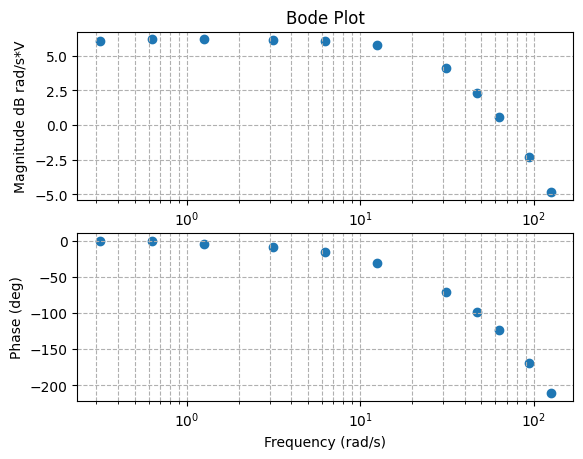

In [67]:
fig, ax = plt.pyplot.subplots(nrows=2, ncols=1)
ax[0].title.set_text('Bode Plot')
ax[0].set_xscale('log')
ax[0].grid(True, which="both", ls="--")
ax[0].scatter(frequencies_rad, mag)
ax[0].set_xlabel('Frequency (rad/s)')
ax[0].set_ylabel('Magnitude dB rad/s*V')

ax[1].set_xscale('log')
ax[1].grid(True, which="both", ls="--")
ax[1].scatter(frequencies_rad, phase_shift2)
ax[1].set_xlabel('Frequency (rad/s)')
ax[1].set_ylabel('Phase (deg)')

In [68]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1)
fig.append_trace(go.Scatter(x = frequencies_rad, y = mag, yaxis="y"), row=1, col=1)
fig.append_trace(go.Scatter(x = frequencies_rad, y = phase_shift2, yaxis="y1", xaxis="x1"), row=2, col=1)
fig.update_xaxes(type="log")
fig.show()

---

# Results

Frequency at $90^\circ $ phase shift is equal to roughly 14.2 radians/second

- The time constant $(\tau)$ can be calculated as: $ \omega_{90^\circ} = \frac{1}{\tau}$

$$ \tau = \frac{1}{\omega_{90^\circ}} = \frac{1}{18} = 0.05555 $$

- Magnitude: 5.8 dB rad/s*V

$$ k_{dc} = 10^{dB/20} = 10^{5.8/20} = 1.94984 $$

$$ T(s) = \frac{1}{\tau s + 1} = \frac{1.94984}{0.05555 s + 1}$$

In [69]:
k_dc = 10**(5.8/20)
print(k_dc)

1.9498445997580451
